In [1]:
suppressPackageStartupMessages({

    library(VariantAnnotation)
    library(tidyverse)
    library(magrittr)
    library(here)
    library(bdkn)
    library(rtracklayer)

})

In [2]:
source(here("src/utils.R"))

In [3]:
gt <- read_gt(here("data/vcf/merged_full.vcf.gz"))

In [4]:
emh_ages <- tibble(
    emh = c("ustishim", "bichon", "kk1", "loschbour", "mota"),
    age = c(45000, 13665, 9720, 8050, 4500)
)
emh_ages

emh,age
ustishim,45000
bichon,13665
kk1,9720
loschbour,8050
mota,4500


In [5]:
ancient <- c("kk1", "mota", "bichon", "loschbour", "ustishim")

In [6]:
archaic <- c("spy1", "mez2", "comb_neand", "denisova8", "denisova8sub", "elsidron1", "elsidron2")

In [7]:
modern <- c(str_subset(colnames(gt), "^S_"), "reference")

In [8]:
pops <- tibble(
    name = modern,
    pop = case_when(
        name == "reference" ~ "reference",
        name %in% c("S_Burmese-1", "S_Thai-1", "S_Han-2", "S_Dai-2", "S_Punjabi-1", "S_Papuan-2", "S_Karitiana-1") ~ "EastEur",
        name %in% c("S_BedouinB-1", "S_Turkish-1", "S_French-1", "S_Finnish-2", "S_Sardinian-1", "S_Saami-2") ~ "WestEur",
        TRUE ~ "Africa"
    )
)

In [9]:
site_patterns <- function(df, w, x, y, z) {
    tibble(
        a = as.integer(df[[w]] == df[[x]] & df[[y]] == df[[z]] & df[[w]] != df[[y]]),
        b = as.integer(df[[w]] == df[[x]] & df[[y]] == df[[z]] & df[[w]] != df[[y]]),
        c = as.integer(df[[w]] == df[[y]] & df[[x]] == df[[z]] & df[[w]] != df[[x]]),
        d = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[z]] & df[[w]] != df[[y]]),
        e = as.integer(df[[w]] == df[[x]] & df[[w]] == df[[y]] & df[[w]] != df[[z]]),
        f = as.integer(df[[w]] == df[[y]] & df[[w]] == df[[z]] & df[[w]] != df[[x]]),
        out_z = as.integer(df[[w]] == df[[z]] & df[[z]] != df[[x]] & df[[z]] != df[[y]]),
        xyz_der = as.integer(df[[w]] != df[[x]] & df[[x]] == df[[y]] & df[[x]] == df[[z]])
    )
}

In [10]:
sum_patterns <- function(gt, w, x, y, z) {
    df <- gt[, c(w, x, y, z)] %>% .[complete.cases(.), ]
    site_patterns(df, w, x, y, z) %>% summarise_all(sum) %>% mutate(total = nrow(df))
}

# Estimating $T_{MRCA}$ of the A00 lineage

In [11]:
a00_counts <- 
    map_dfr(modern, function(ref) {
        map_dfr(ancient, function(emh) {
            sum_patterns(gt, w = "chimp", x = "a00", y = ref, z = emh) %>%
                mutate(ref = ref, emh = emh)
        })
    }) %>%
        inner_join(emh_ages) %>% 
        inner_join(pops, by = c("ref" = "name"))

Joining, by = "emh"


In [12]:
a00 <- a00_counts %>%
    mutate(
        muts_per_year = (d - e) / age,
        mut_rate = muts_per_year / total,
        tmrca_ad = (a + d) / (mut_rate * total),
        tmrca_f = f / (mut_rate * total),
        tmrca_avg = (tmrca_ad + tmrca_f) / 2,
        tmrca_ratio = tmrca_ad / tmrca_f
    )

Lippold all SNPs - WGS mutation rate and A00 divergence:

In [38]:
group_by(a00, emh) %>% summarise_if(is.numeric, mean)

emh,a,d,e,f,chimp_emh,hum_der,total,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
bichon,52.80,27.90,16.75,59.95,0.45,13014.60,285545.0,13665,0.0008159532,2.853818e-09,381848.3,283714.8,332781.6,1.346523
kk1,72.10,34.10,25.00,75.75,0.45,17793.55,412587.7,9720,0.0009362140,2.267315e-09,347814.9,248105.9,297960.4,1.402212
loschbour,84.25,46.95,24.70,83.80,1.40,20304.90,484517.7,8050,0.0027639752,5.698763e-09,365860.4,233725.1,299792.7,1.565685
mota,58.75,44.30,25.50,75.20,0.00,17740.90,423599.1,4500,0.0041777778,9.855787e-09,328701.4,239900.3,284300.8,1.370089
ustishim,81.90,45.50,10.25,81.75,0.45,20729.00,491521.3,45000,0.0007833333,1.592648e-09,350199.0,224758.2,287478.6,1.558411


All SNPs:

In [13]:
group_by(a00, emh) %>% summarise_if(is.numeric, mean)

emh,a,b,c,d,e,f,out_z,xyz_der,total,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
bichon,531.30,531.30,5.65,129.75,77.80,576.05,4.30,109367.6,3160471,13665,0.003801683,1.203167e-09,181245.5,158521.6,169883.5,1.147614
kk1,819.80,819.80,7.25,182.05,119.55,862.65,4.70,161287.0,4906332,9720,0.006430041,1.311053e-09,171211.2,148323.5,159767.3,1.161415
loschbour,972.95,972.95,9.00,243.95,180.65,1053.00,14.90,193738.0,6013776,8050,0.007863354,1.307479e-09,163984.9,142353.5,153169.2,1.155658
mota,808.80,808.80,7.40,226.65,202.85,922.25,5.25,168790.3,5254046,4500,0.005288889,1.007256e-09,536215.5,485358.3,510786.9,1.122777
ustishim,966.95,966.95,10.00,243.10,48.15,1037.35,2.50,194935.0,6057638,45000,0.004332222,7.151393e-10,280377.4,240541.6,260459.5,1.166484


TV-only SNPs:

In [13]:
group_by(a00, emh) %>% summarise_if(is.numeric, mean)

emh,a,d,e,f,chimp_emh,hum_der,total,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
bichon,182.25,47.75,32.40,215.30,1.9,43656.25,3092503,13665,0.0011233077,3.632419e-10,Inf,Inf,Inf,NaN
kk1,281.35,67.00,55.10,324.90,3.3,64823.20,4806536,9720,0.0012242798,2.546768e-10,767137.3,731194.2,749165.7,1.072197
loschbour,344.75,92.65,61.80,397.65,3.9,77859.90,5893830,8050,0.0038322981,6.501212e-10,136380.7,125500.2,130940.4,1.099976
mota,278.70,88.40,84.70,345.45,0.1,67619.75,5149427,4500,0.0008222222,1.596792e-10,Inf,Inf,Inf,NaN
ustishim,337.00,92.55,21.35,397.40,0.1,78640.75,5937346,45000,0.0015822222,2.664665e-10,275920.7,256068.2,265994.5,1.080894


Lippold all SNPs:

In [36]:
group_by(a00, emh) %>% summarise_if(is.numeric, mean)

emh,a,d,e,f,chimp_emh,hum_der,total,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
bichon,52.80,27.90,16.75,59.95,0.45,13014.60,285545.0,13665,0.0008159532,2.853818e-09,97132.95,73056.74,85094.85,1.346523
kk1,72.10,34.10,25.00,75.75,0.45,17793.55,412587.7,9720,0.0009362140,2.267315e-09,144036.41,105651.98,124844.19,1.402212
loschbour,84.25,46.95,24.70,83.80,1.40,20304.90,484517.7,8050,0.0027639752,5.698763e-09,73822.94,50220.24,62021.59,1.565685
mota,58.75,44.30,25.50,75.20,0.00,17740.90,423599.1,4500,0.0041777778,9.855787e-09,20257.53,13258.17,16757.85,1.370089
ustishim,81.90,45.50,10.25,81.75,0.45,20729.00,491521.3,45000,0.0007833333,1.592648e-09,145777.40,89545.05,117661.22,1.558411


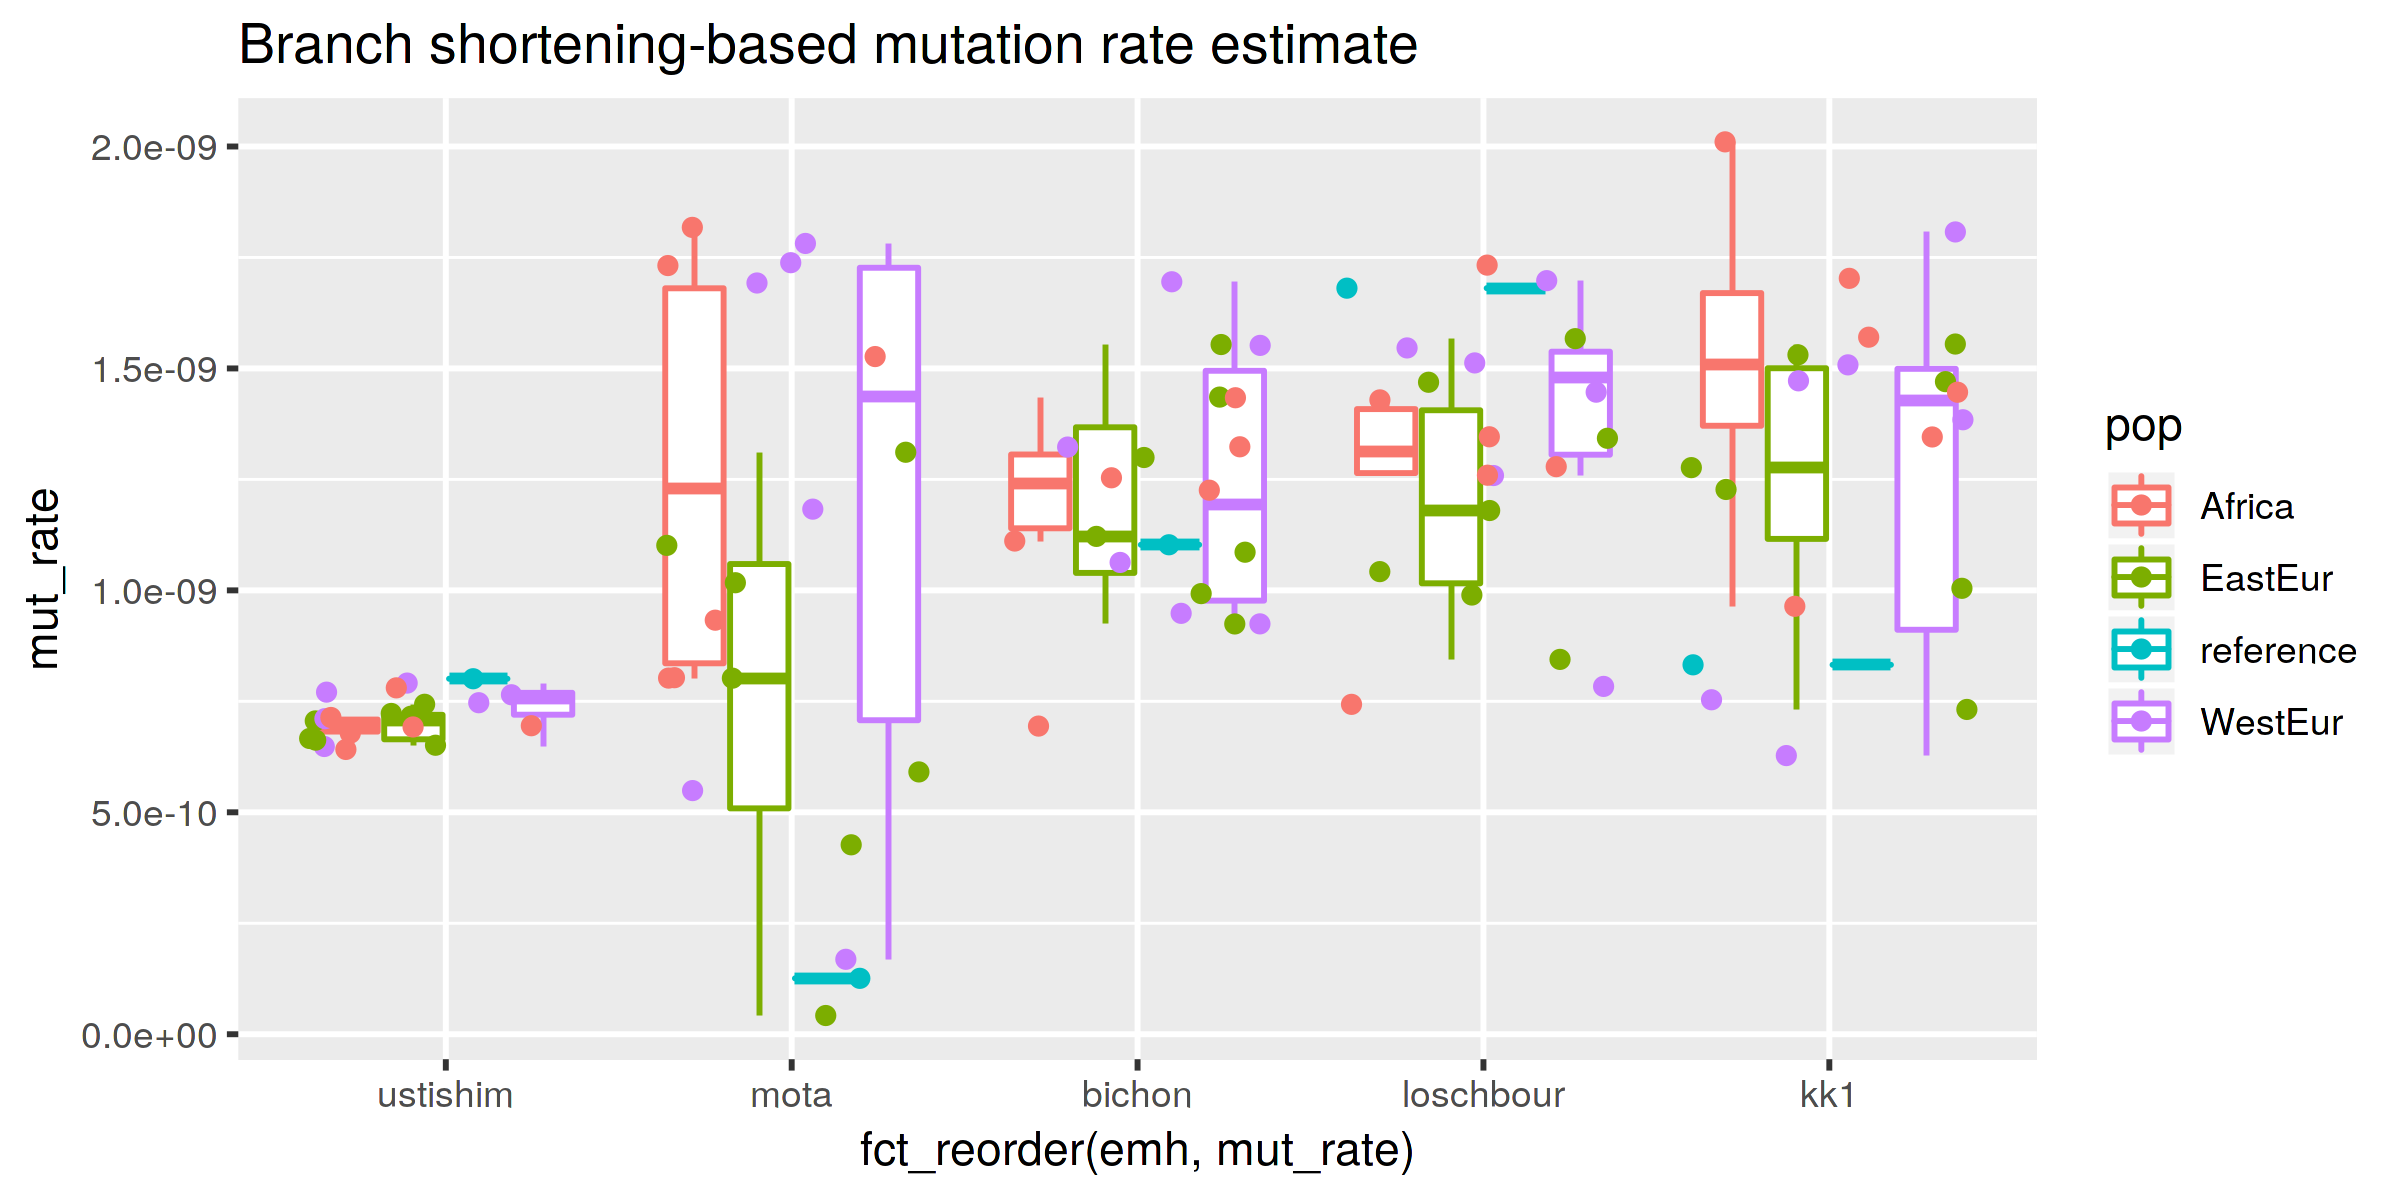

In [14]:
set_dim(8, 4, 300)

a00 %>%
ggplot(aes(fct_reorder(emh, mut_rate), mut_rate, color = pop)) +
    geom_boxplot(outlier.shape = NA) + geom_jitter() +
    ggtitle("Branch shortening-based mutation rate estimate")

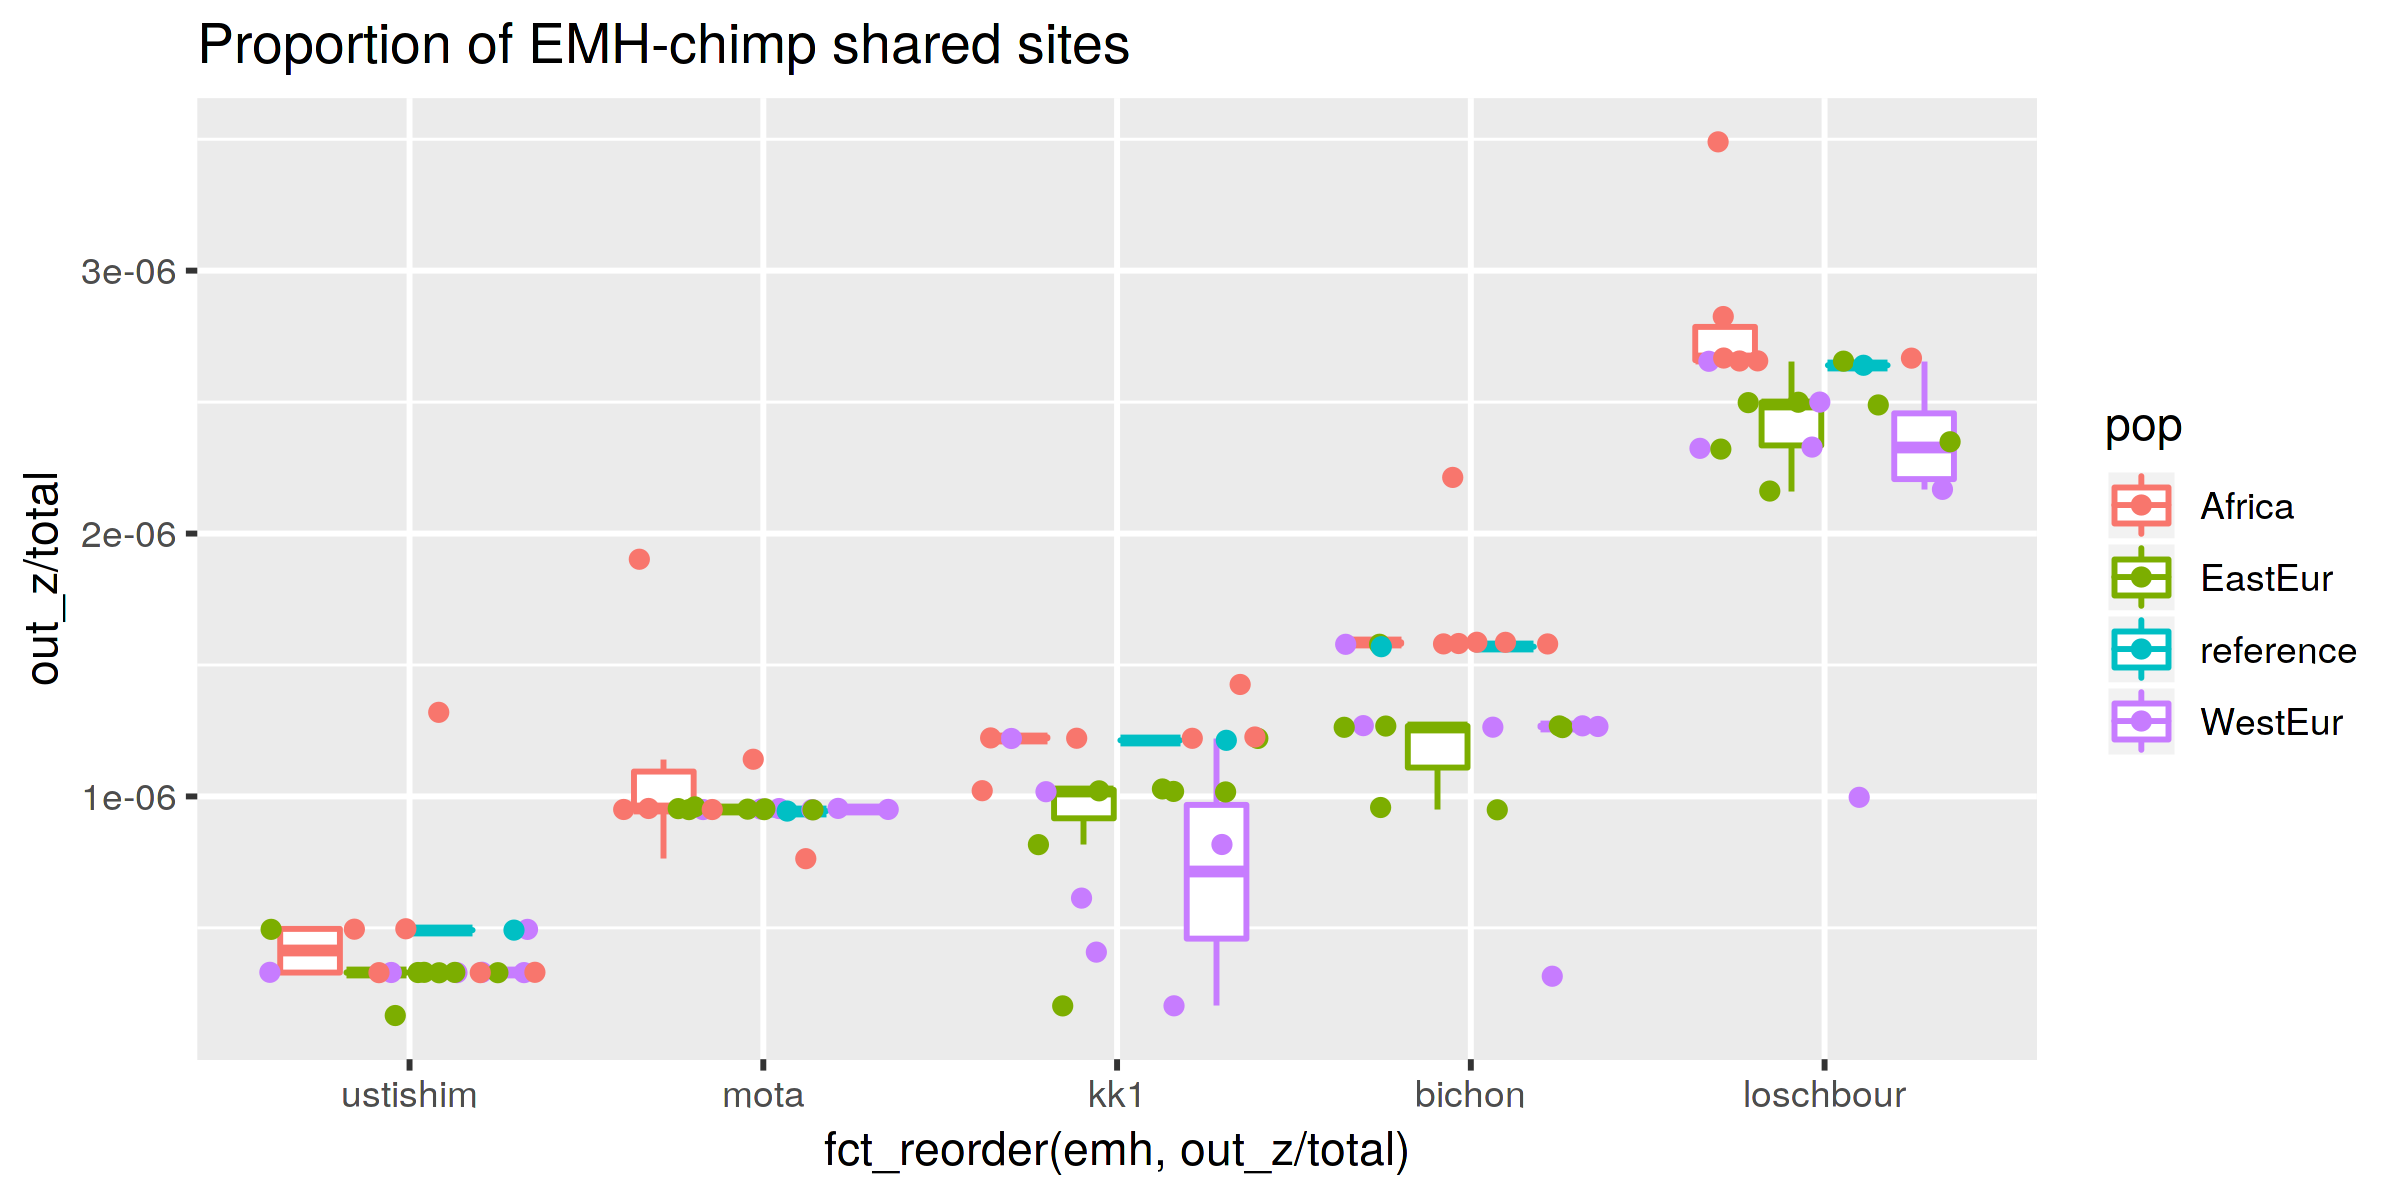

In [15]:
set_dim(8, 4, 300)

a00 %>%
ggplot(aes(fct_reorder(emh, out_z / total), out_z / total, color = pop)) +
    geom_boxplot(outlier.shape = NA) + geom_jitter() +
    ggtitle("Proportion of EMH-chimp shared sites")

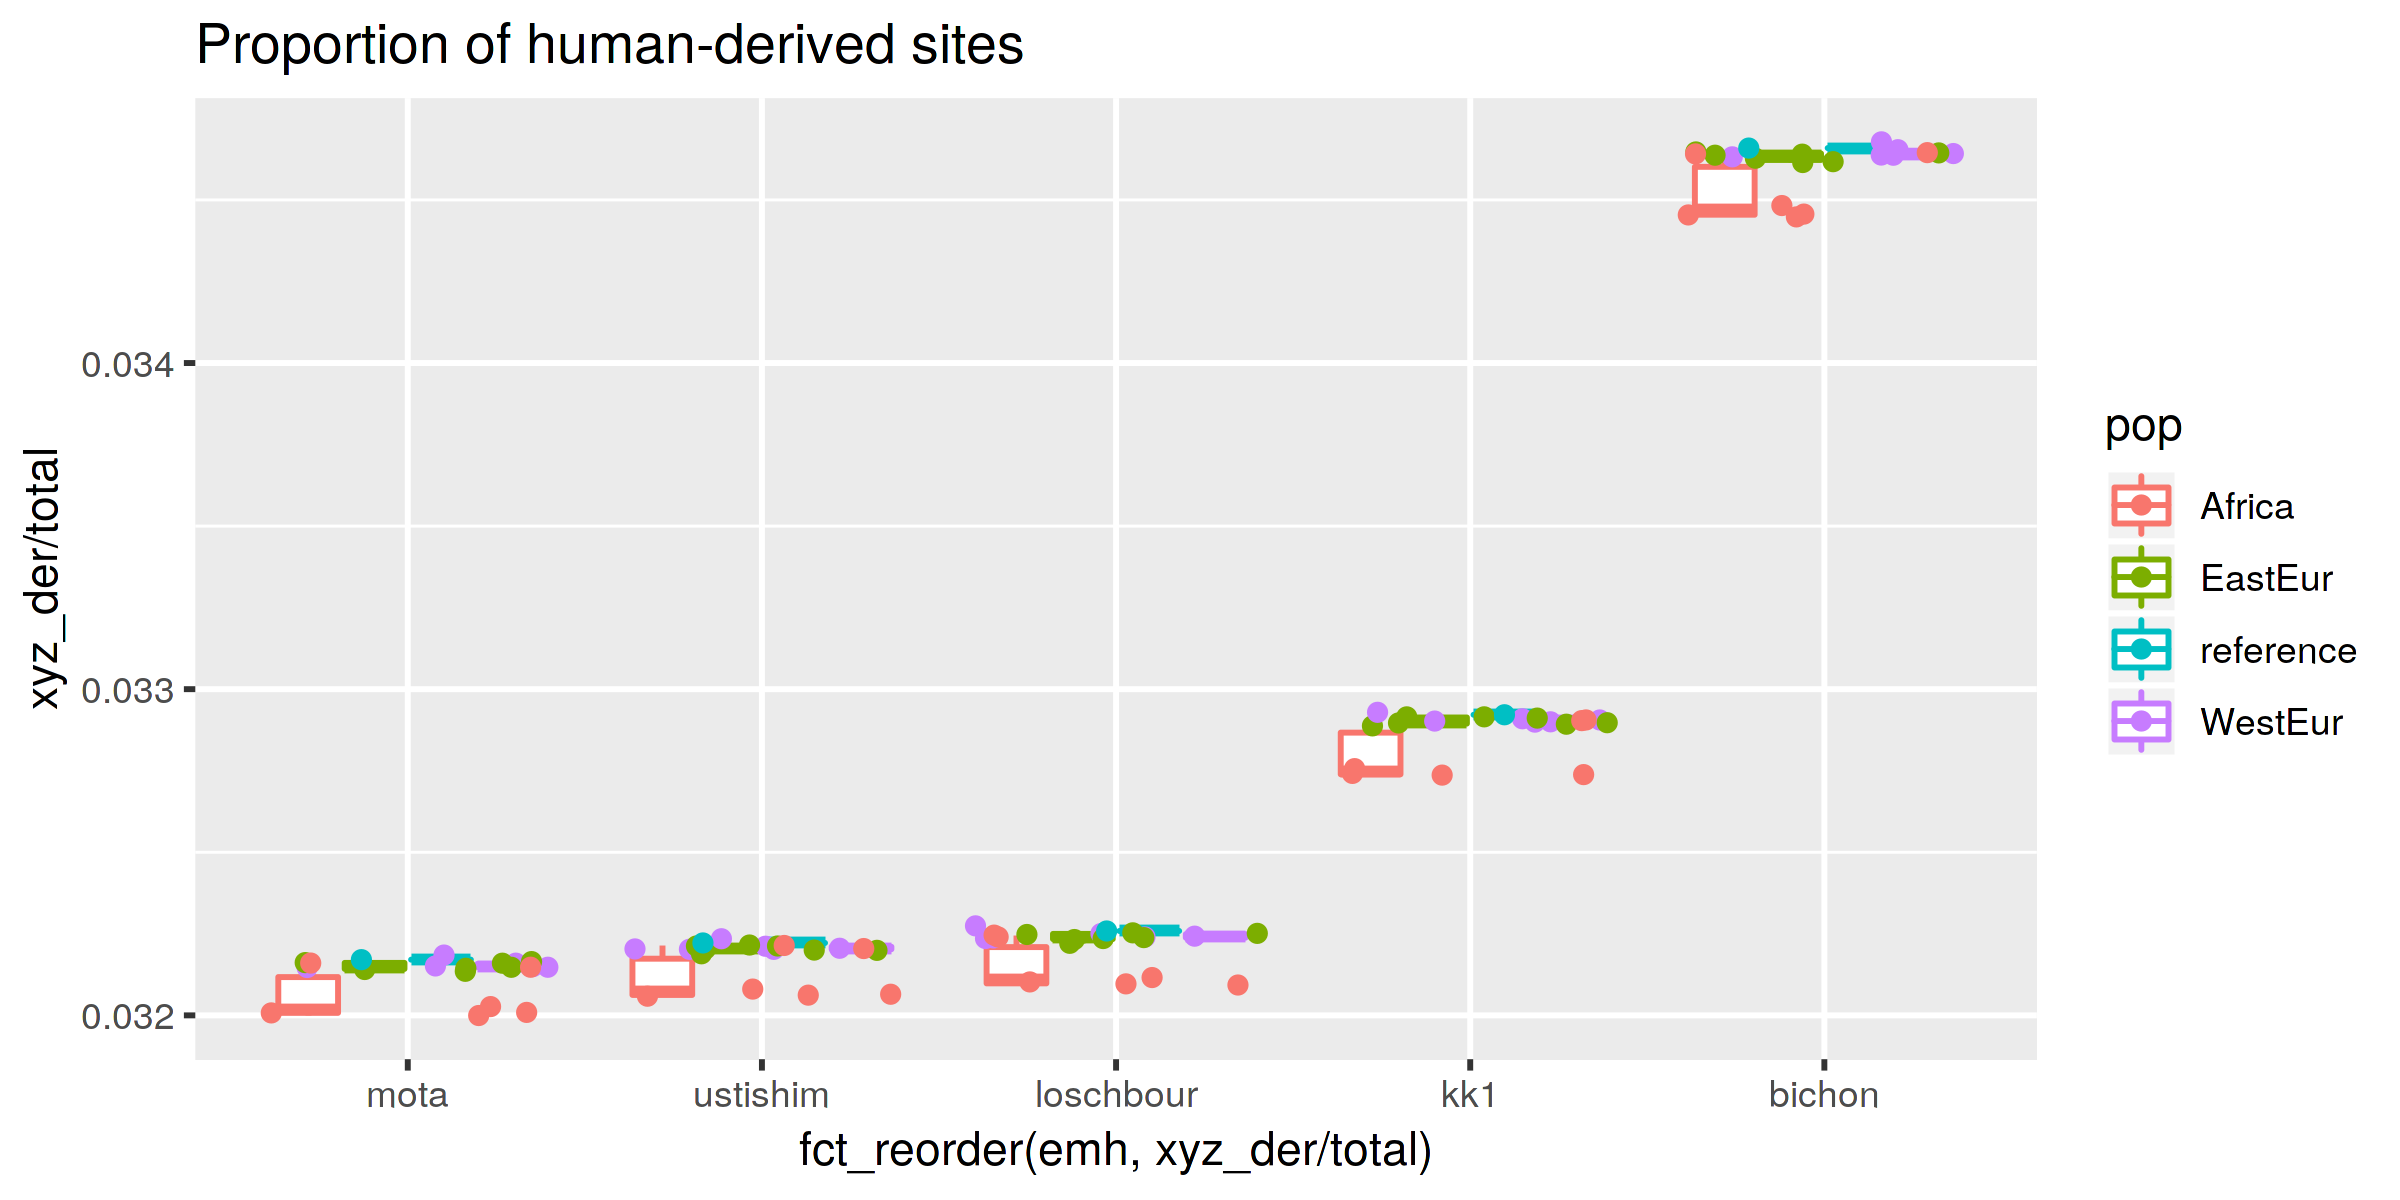

In [16]:
set_dim(8, 4, 300)

a00 %>%
ggplot(aes(fct_reorder(emh, xyz_der / total), xyz_der / total, color = pop)) +
    geom_boxplot(outlier.shape = NA) + geom_jitter() +
    ggtitle("Proportion of human-derived sites")

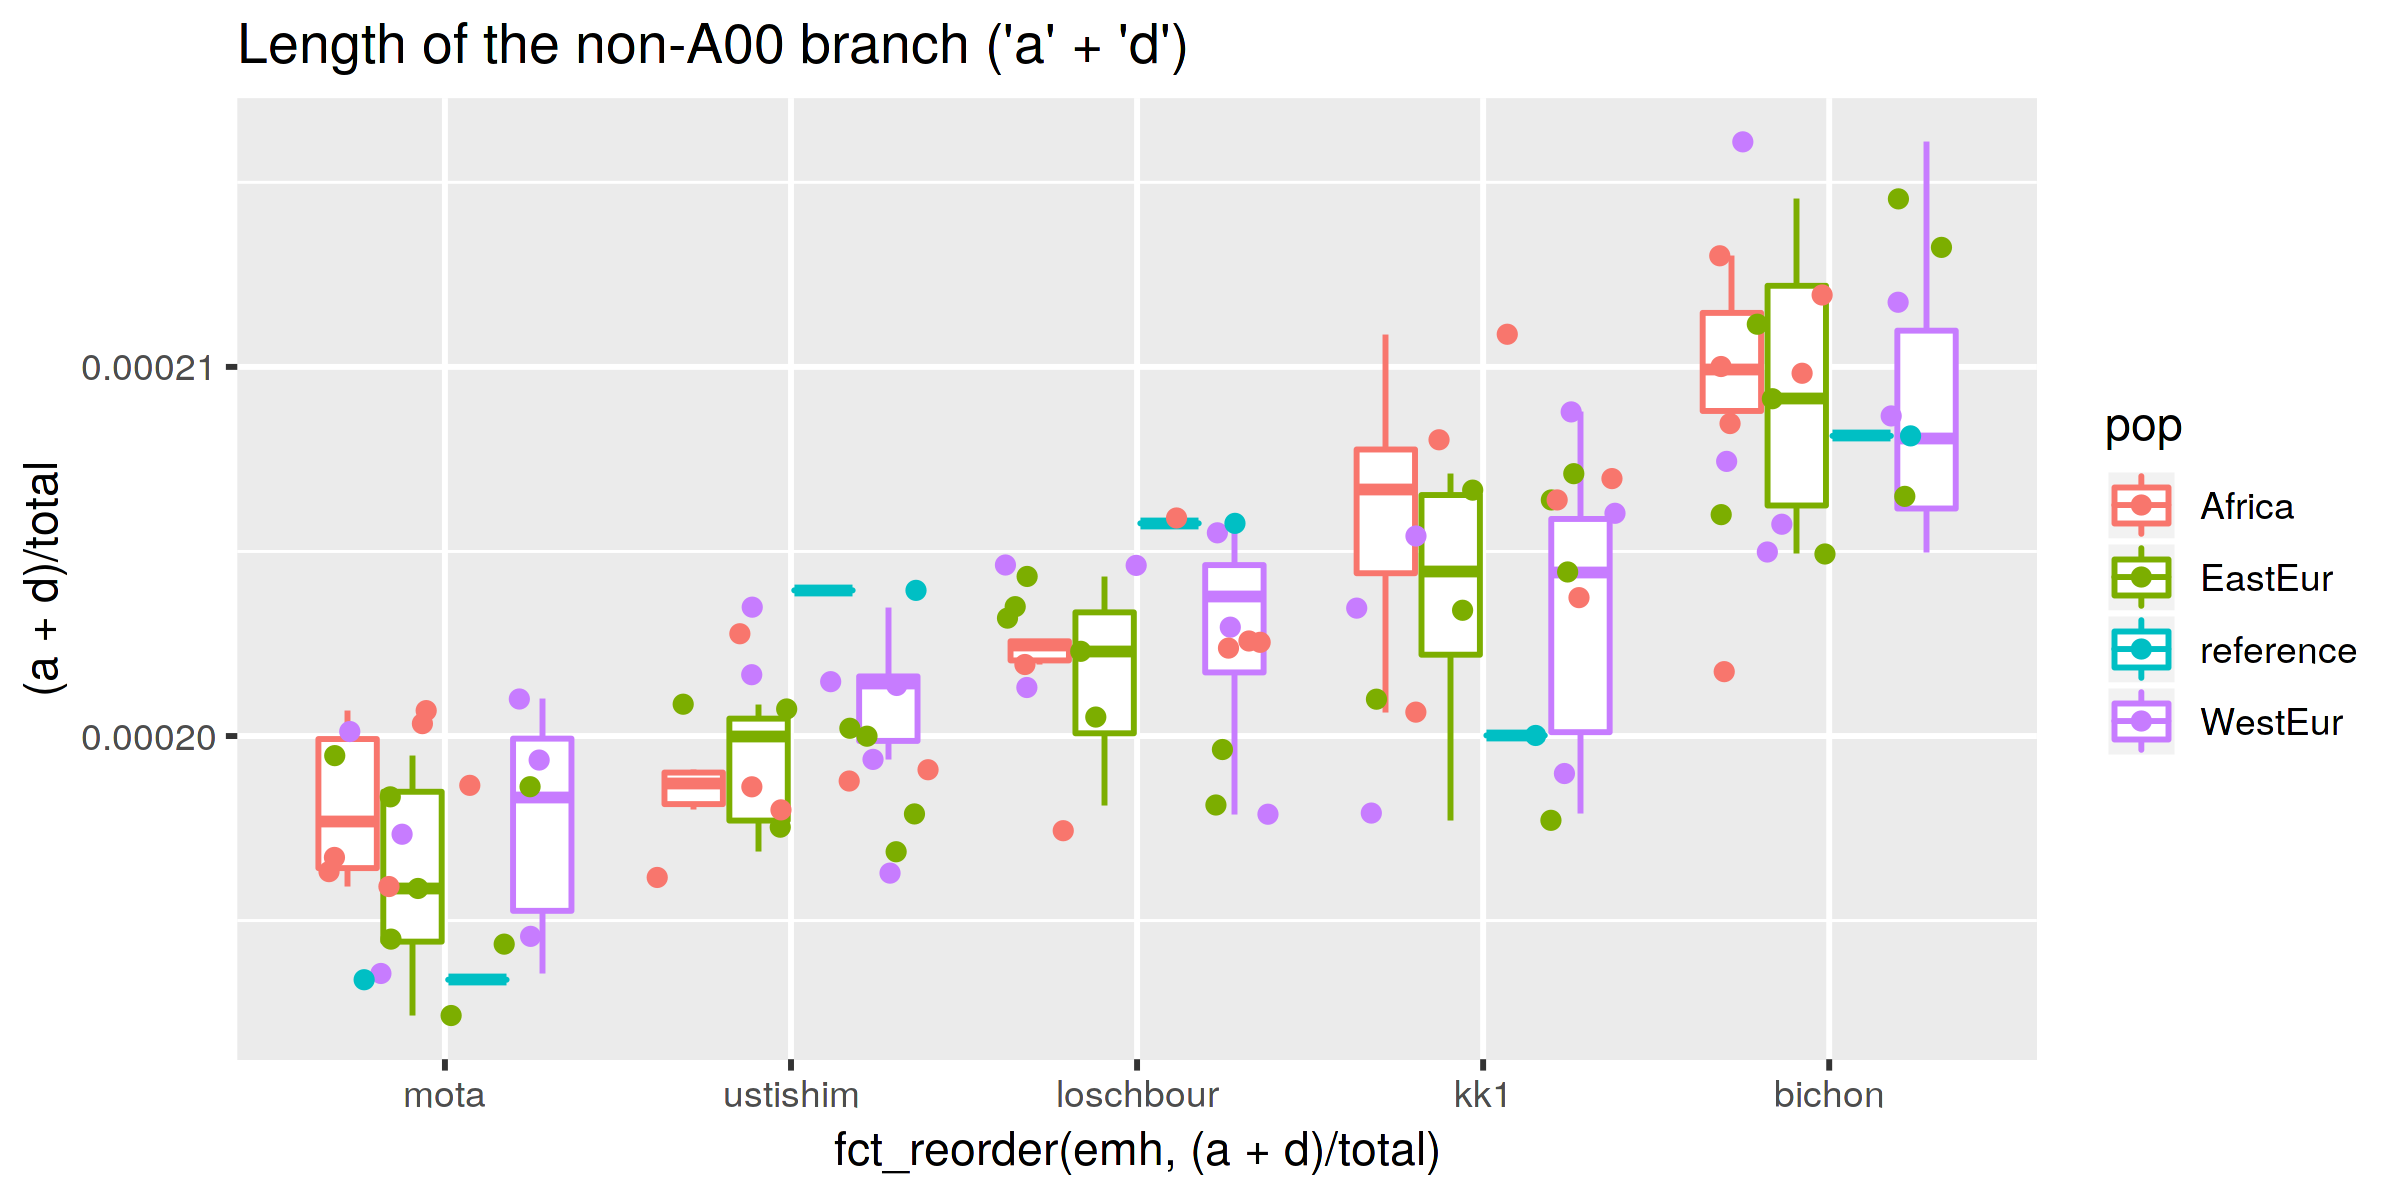

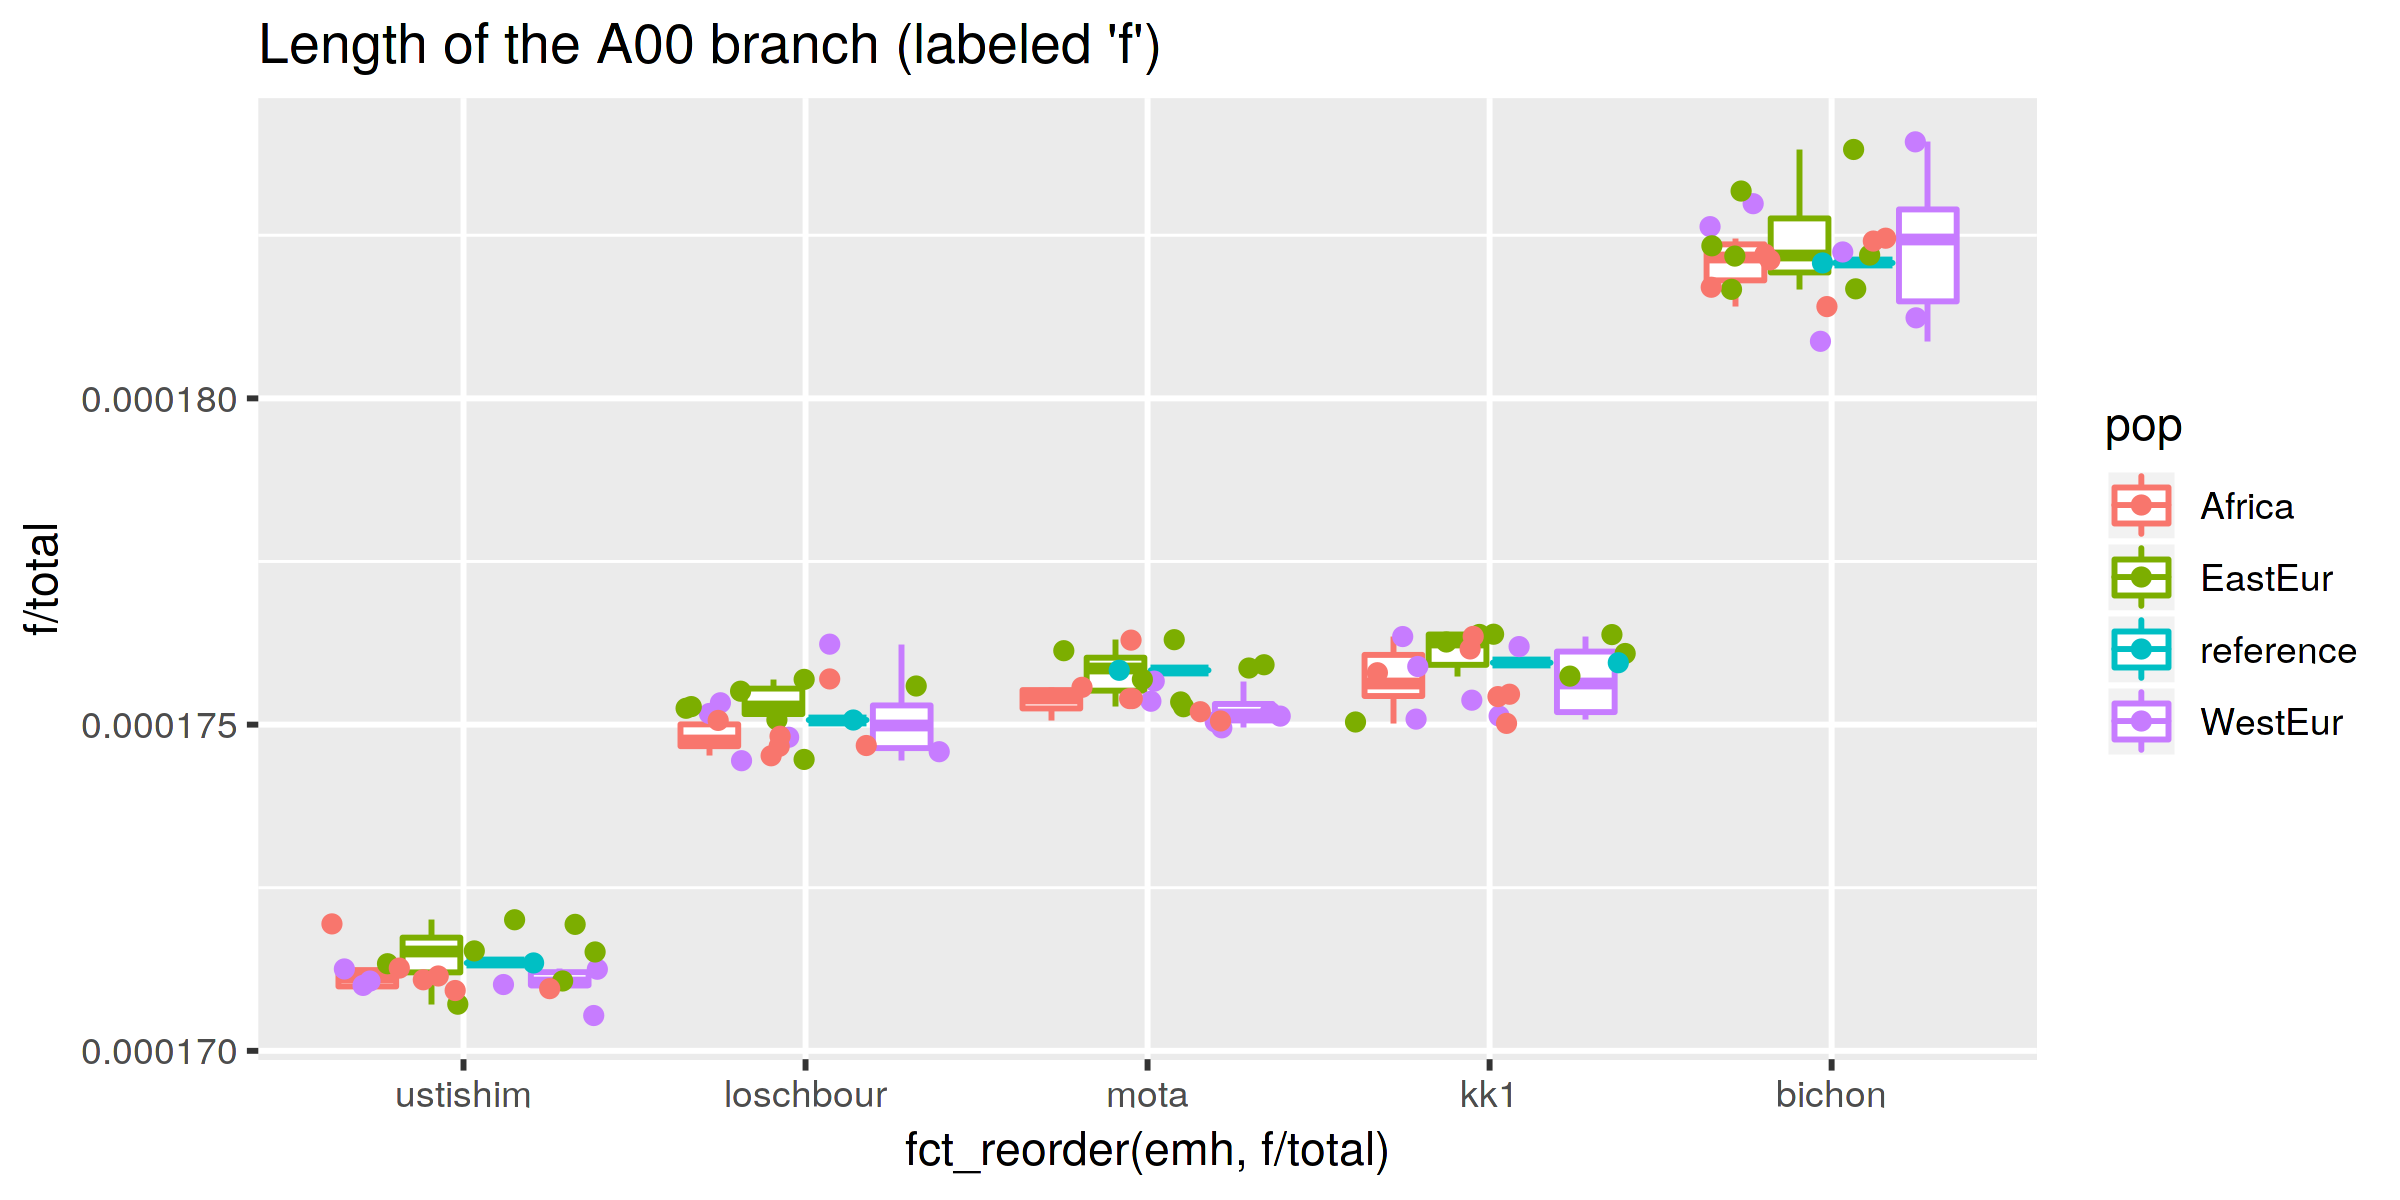

In [22]:
set_dim(8, 4, 300)

a00 %>%
ggplot(aes(fct_reorder(emh, (a + d) / total), (a + d) / total, color = pop)) +
    geom_boxplot(outlier.shape = NA) + geom_jitter() +
    ggtitle("Length of the non-A00 branch ('a' + 'd')")

a00 %>%
ggplot(aes(fct_reorder(emh, f / total), f / total, color = pop)) +
    geom_boxplot(outlier.shape = NA) + geom_jitter() +
    ggtitle("Length of the A00 branch (labeled 'f')")

### Final estimates based on the Ust'-Ishim individual

All SNPs:

In [18]:
t_a00 <- a00 %>%
    filter(emh == "ustishim") %>%
    select(mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    summarise_all(mean)

t_a00

mut_rate,tmrca_ad,tmrca_f,tmrca_avg
7.151393e-10,280377.4,240541.6,260459.5


TV-only SNPs:

In [14]:
t_a00 <- a00 %>%
    filter(emh == "ustishim") %>%
    select(mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    summarise_all(mean)

t_a00

mut_rate,tmrca_ad,tmrca_f,tmrca_avg
2.664665e-10,275920.7,256068.2,265994.5


Lippold all SNPs:

In [14]:
t_a00 <- a00 %>%
    filter(emh == "ustishim") %>%
    select(mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    summarise_all(mean)

t_a00

mut_rate,tmrca_ad,tmrca_f,tmrca_avg
1.592648e-09,145777.4,89545.05,117661.2


Lippold all SNPs - WGS mutation rate and A00 divergence:

In [44]:
t_a00 <- a00 %>%
    filter(emh == "ustishim") %>%
    select(mut_rate, tmrca_ad, tmrca_f, tmrca_avg) %>%
    summarise_all(mean)

t_a00

mut_rate,tmrca_ad,tmrca_f,tmrca_avg
1.592648e-09,350199,224758.2,287478.6


# Estimating the $\alpha$ parameter

## Method 1

$$\frac{T_a}{T_a + T_d + T_e} = \frac{T_{NM}}{T_{NM} + 2T_{AR}} = \frac{(\alpha - 1)T_{AR}}{(\alpha - 1)T_{AR} + 2T_{AR}} = \frac{\alpha - 1}{\alpha + 1} = p \implies \alpha = \frac{1 + p}{1 - p}$$

In [20]:
arch_counts <- 
    map_dfr(modern, function(ref) {
        map_dfr(archaic, function(arch) {
            if (!arch %in% colnames(gt)) return(NULL)
            sum_patterns(gt, w = "chimp", x = arch, y = ref, z = "a00") %>%
                mutate(ref = ref, archaic = arch)
        })
    }) %>%
        inner_join(pops, by = c("ref" = "name"))

In [29]:
arch <- arch_counts %>%
    mutate(p = a / (a + d + e),
           alpha = (1 + p) / (1 - p),
           tmrca_arch = t_a00$tmrca_avg * alpha)

All SNPs:

In [30]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,b,c,d,e,f,out_z,xyz_der,total,p,alpha,tmrca_arch
comb_neand,84.30,84.30,3.75,176.70,224.70,272.75,10.40,45366.35,1393734.0,0.1736414,1.420316,369934.9
mez2,34.90,34.90,1.85,73.30,90.00,140.75,7.05,19782.20,554061.6,0.1761678,1.427783,371879.7
spy1,15.80,15.80,0.30,23.70,35.80,174.50,4.50,7011.70,231241.4,0.2104426,1.533710,399469.3
denisova8sub,253.50,253.50,7.80,161.20,244.85,313.60,10.45,46099.00,1443844.9,0.3845092,2.250029,586041.5
denisova8,538.05,538.05,12.55,315.95,438.15,648.70,22.40,82700.70,2591169.5,0.4164547,2.427583,632287.1


In [23]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,b,c,d,e,f,out_z,xyz_der,total,p,alpha,tmrca_arch
comb_neand,84.30,84.30,3.75,176.70,224.70,272.75,10.40,45366.35,1393734.0,0.1736414,1.420316,369934.9
mez2,34.90,34.90,1.85,73.30,90.00,140.75,7.05,19782.20,554061.6,0.1761678,1.427783,371879.7
spy1,15.80,15.80,0.30,23.70,35.80,174.50,4.50,7011.70,231241.4,0.2104426,1.533710,399469.3
denisova8sub,253.50,253.50,7.80,161.20,244.85,313.60,10.45,46099.00,1443844.9,0.3845092,2.250029,586041.5
denisova8,538.05,538.05,12.55,315.95,438.15,648.70,22.40,82700.70,2591169.5,0.4164547,2.427583,632287.1


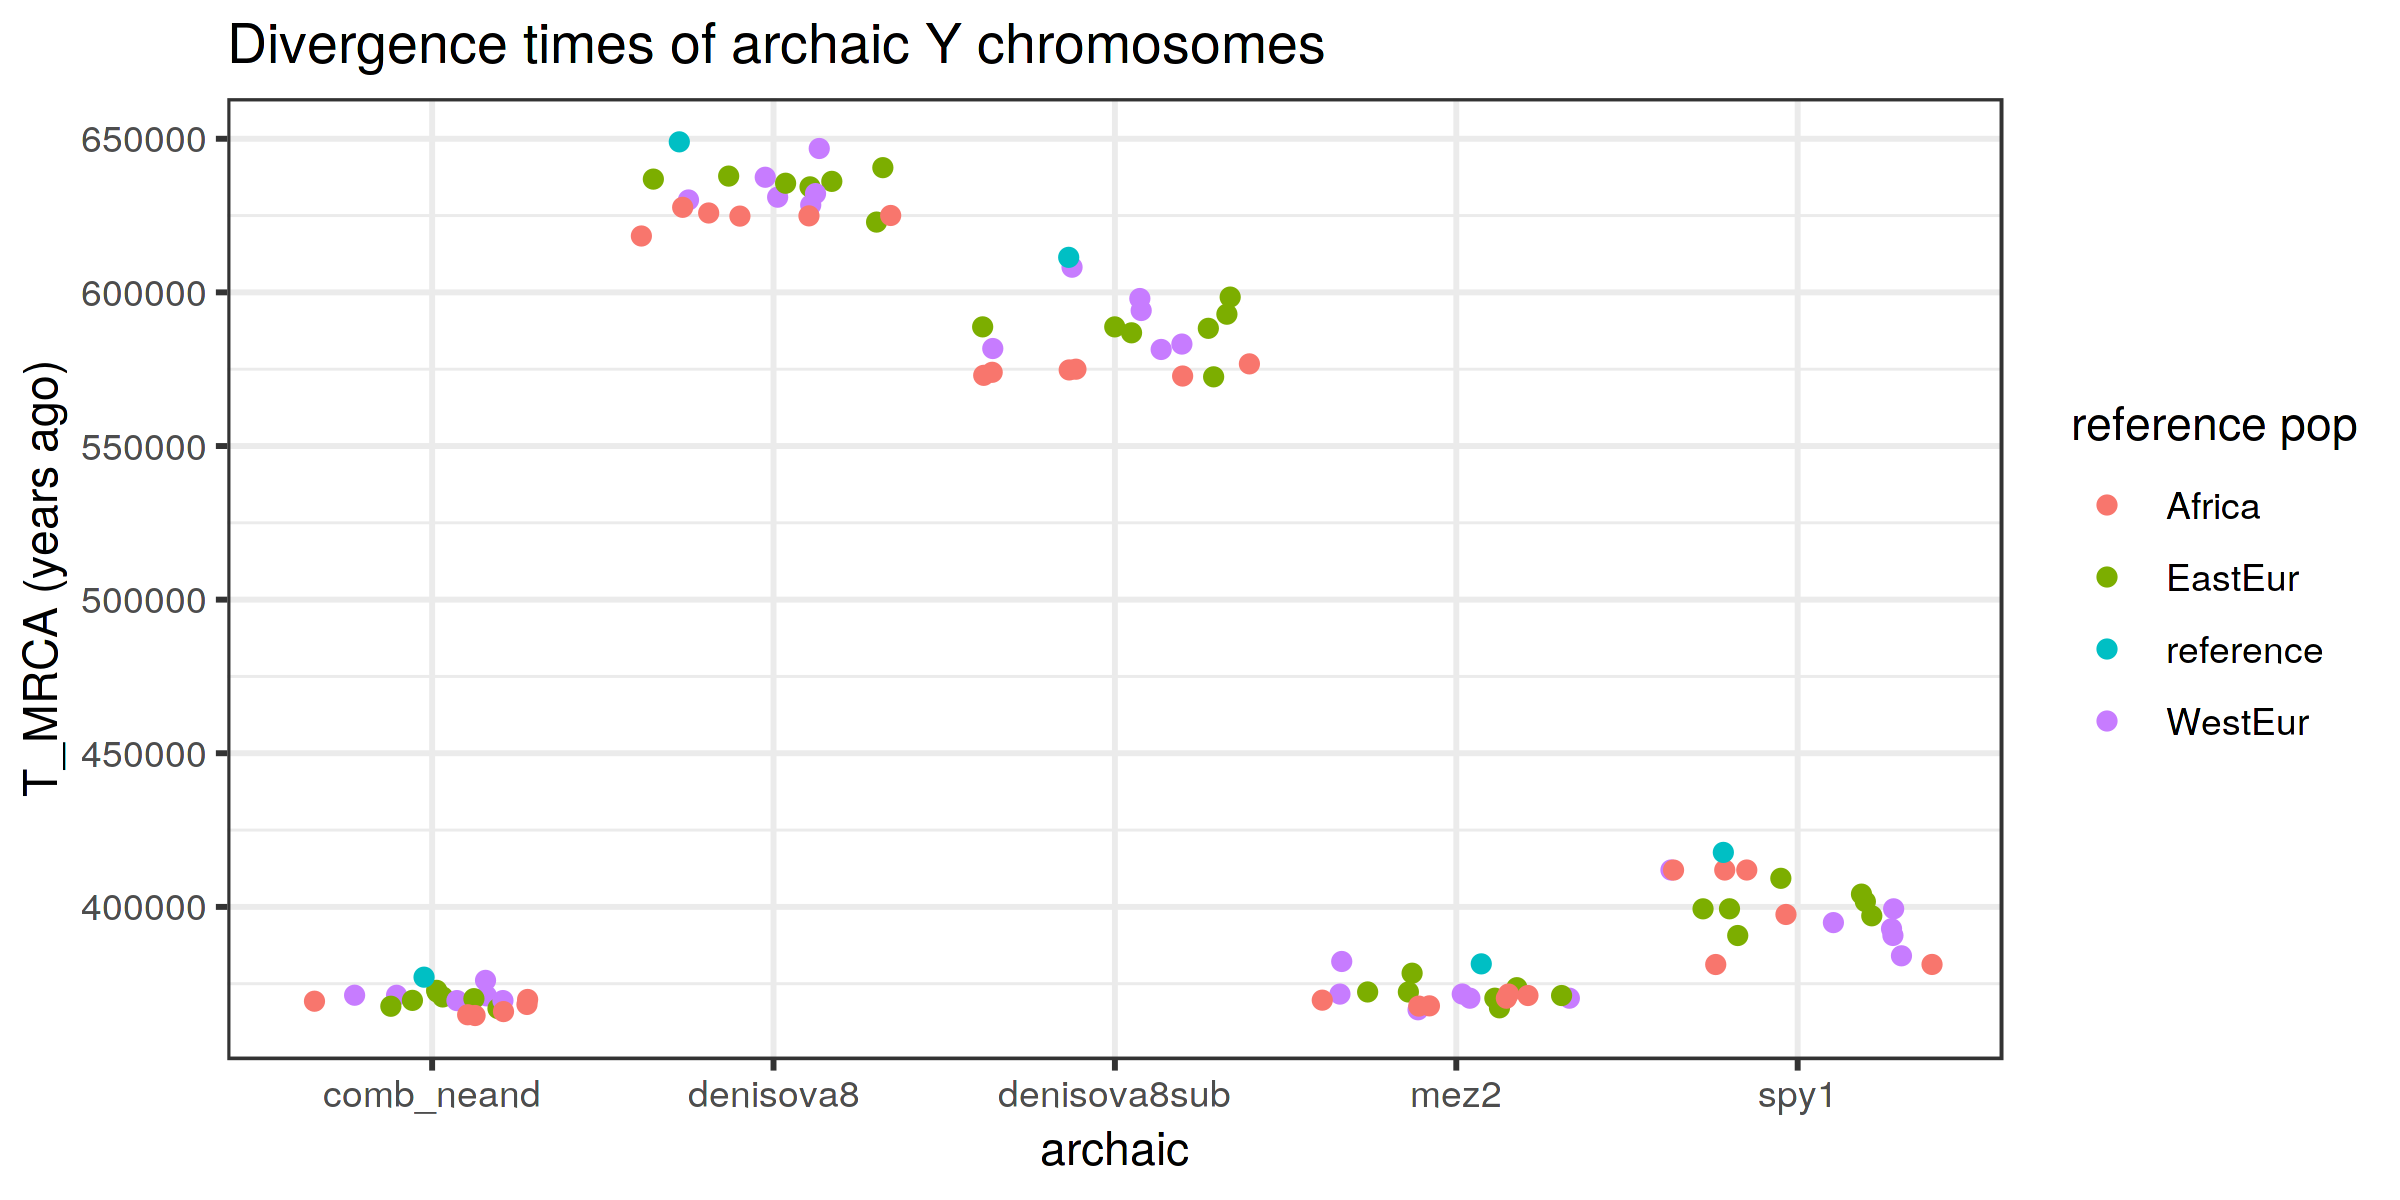

In [24]:
arch %>%
    ggplot(aes(archaic, tmrca_arch, color = pop)) +
    geom_jitter() +
    ylab("T_MRCA (years ago)") +
    guides(color = guide_legend("reference pop")) +
    ggtitle("Divergence times of archaic Y chromosomes") +
    theme_bw()

TV-only SNPs:

In [19]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,d,e,f,total,p,alpha,tmrca_arch
mez2,10.80,25.75,30.65,26.85,541671.6,0.1608888,1.383694,368054.9
spy1,3.95,6.15,13.90,28.65,226763.8,0.1659212,1.398843,372084.4
comb_neand,30.40,59.20,85.15,67.35,1365402.0,0.1740555,1.421563,378128.0
denisova8,205.85,113.35,170.40,238.80,2539513.0,0.4206619,2.453204,652538.6


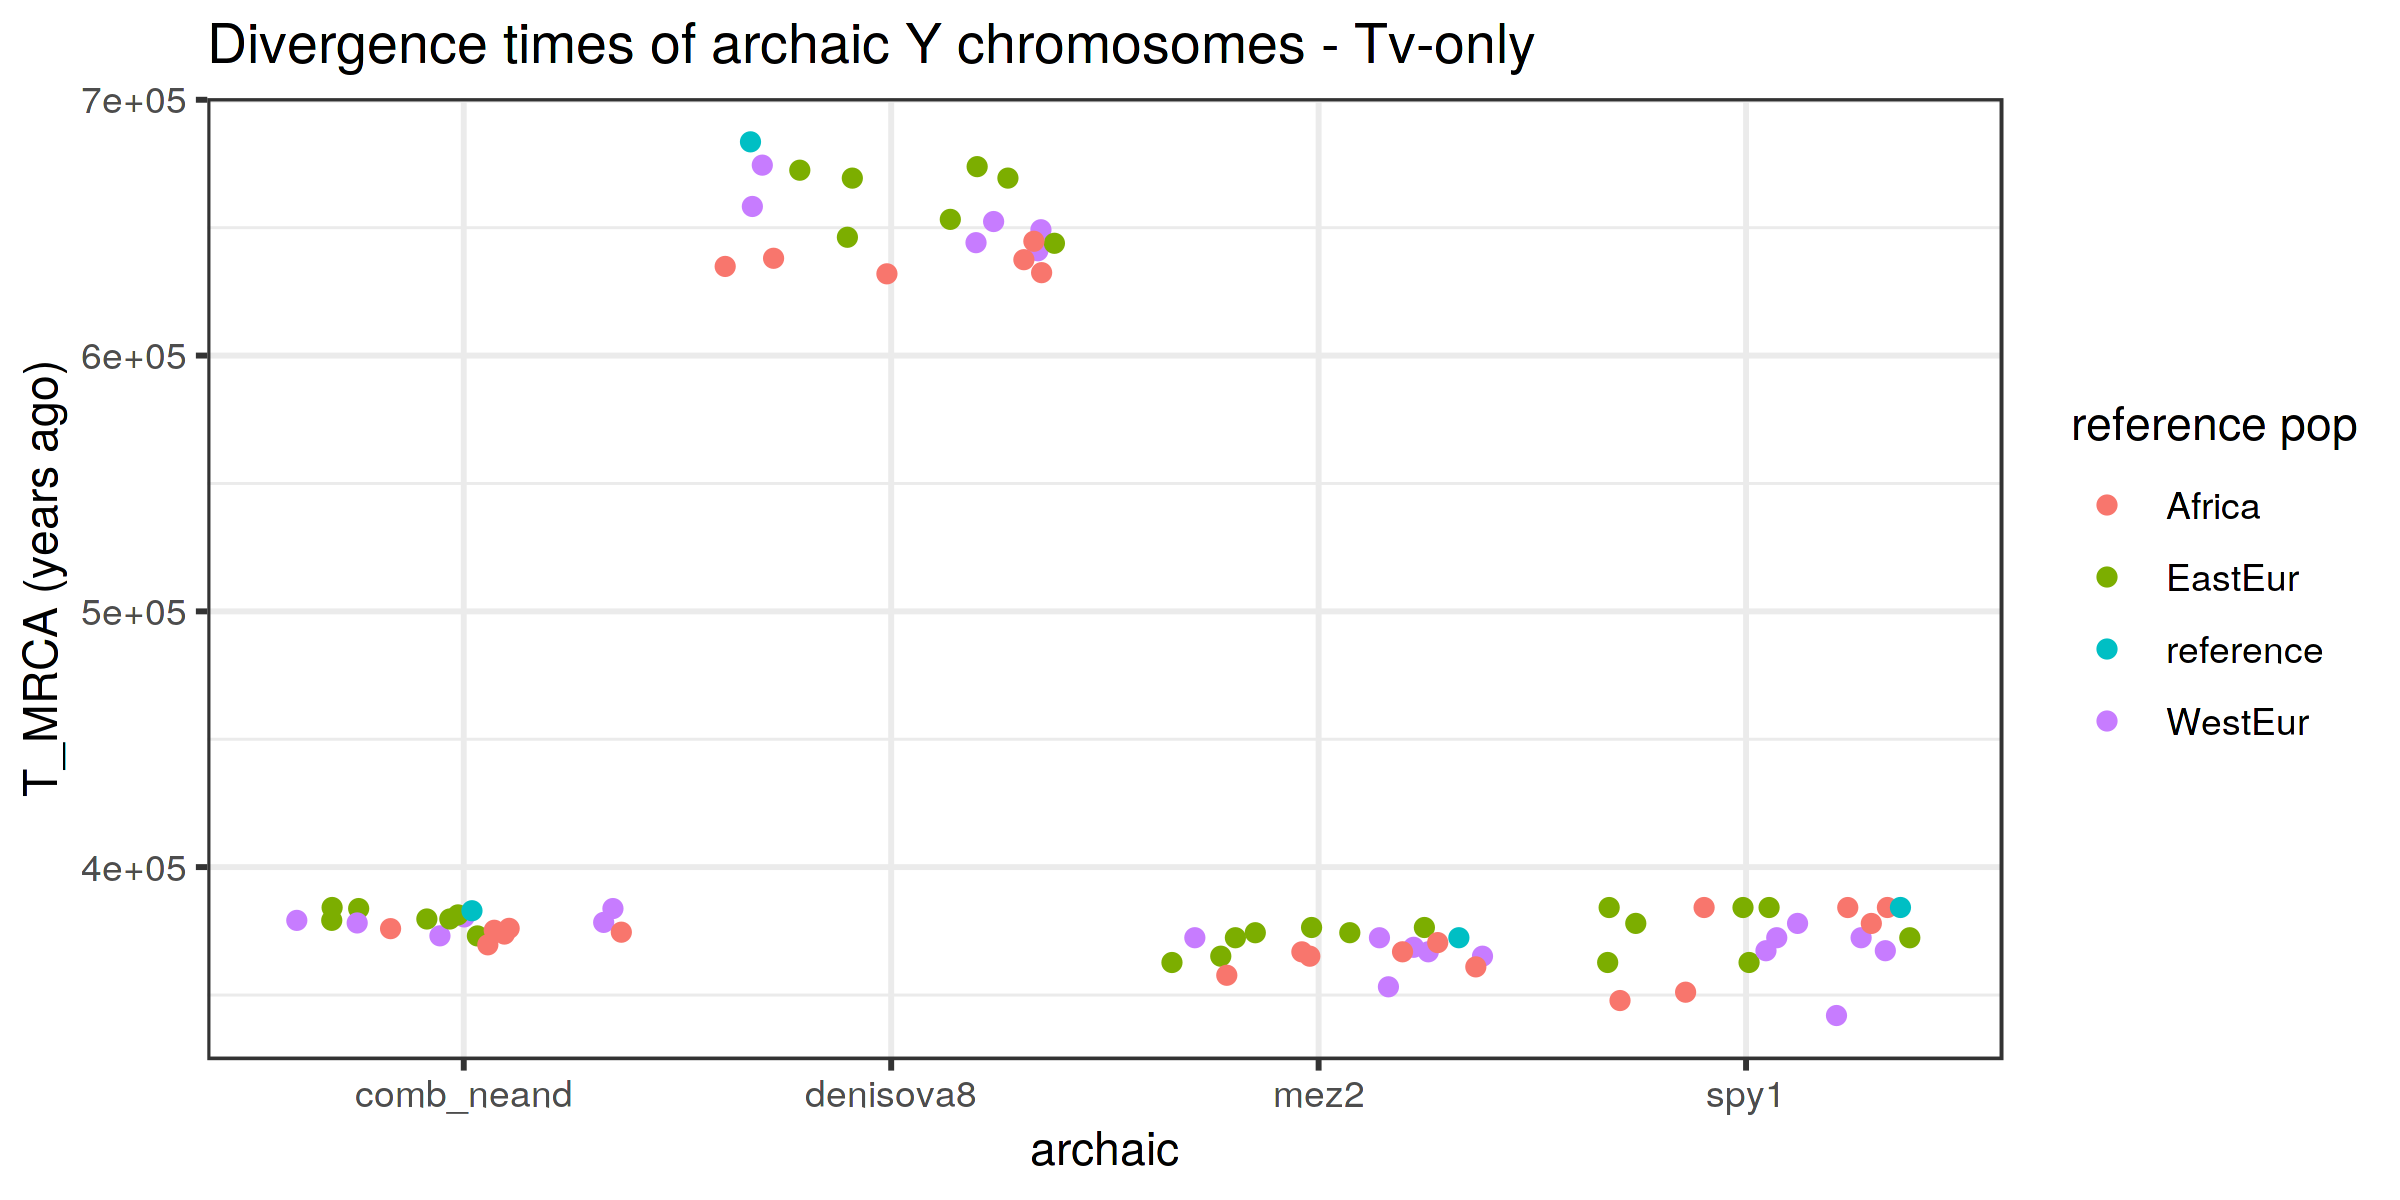

In [22]:
set_dim(8, 4, 300)

arch %>%
    ggplot(aes(archaic, tmrca_arch, color = pop)) +
    geom_jitter() +
    ylab("T_MRCA (years ago)") +
    guides(color = guide_legend("reference pop")) +
    ggtitle("Divergence times of archaic Y chromosomes - Tv-only") +
    theme_bw()

Lippold all SNPs - mutation rate and A00 divergence estimated from WGS:

In [46]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,d,e,f,total,p,alpha,tmrca_arch
elsidron2,42.65,102.9,67.20,85.1,400990.6,0.2020359,1.507553,433389.4
comb_neand,11.05,23.9,18.75,18.9,120269.4,0.2070237,1.523550,437988.0
denisova8,50.20,49.1,35.50,49.5,237486.9,0.3739604,2.199577,632331.4


Lippold all SNPs:

In [17]:
arch %>%
    group_by(archaic) %>%
    summarise_if(is.numeric, mean) %>%
    arrange(tmrca_arch)

archaic,a,d,e,f,total,p,alpha,tmrca_arch
elsidron2,42.65,102.9,67.20,85.1,400990.6,0.2020359,1.507553,177380.6
comb_neand,11.05,23.9,18.75,18.9,120269.4,0.2070237,1.523550,179262.7
denisova8,50.20,49.1,35.50,49.5,237486.9,0.3739604,2.199577,258804.9


In [33]:
mendez_a00_counts <- tibble(
    a = 1434, d = 305, e = 19, f = 1591,
    total = 7830000,
    ref = "reference", emh = "ustishim", age = 45000
)

In [34]:
mendez_a00_counts %>%
    mutate(
        muts_per_year = (d - e) / age,
        mut_rate = muts_per_year / total,
        tmrca_ad = (a + d) / (mut_rate * total),
        tmrca_f = f / (mut_rate * total),
        tmrca_avg = (tmrca_ad + tmrca_f) / 2,
        tmrca_ratio = tmrca_ad / tmrca_f
    )

a,d,e,f,total,ref,emh,age,muts_per_year,mut_rate,tmrca_ad,tmrca_f,tmrca_avg,tmrca_ratio
1434,305,19,1591,7830000,reference,ustishim,45000,0.006355556,8.116929e-10,273618.9,250332.2,261975.5,1.093023
